In [1]:
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [74]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [3]:
final_dataset = pd.read_csv('final_dataset_homer.csv')

In [4]:
final_dataset.head(3)

,Unnamed: 0,A,Q,Context,len_Context,label
0,3,Me?,I'm glad I'm not crying because I would hate f...,Mr. Bergstrom left today. He's gone. Forever. ...,4.0,1.0
1,4,I don't think you realize what you're saying.,"Yes, you! Baboon, baboon, baboon, baboon!",He's gone. Forever. I didn't think you'd under...,4.0,1.0
2,5,"Did you hear that, Marge? She called me a babo...","Whoa, somebody was bound to say it one day. I ...",I didn't think you'd understand. I'm glad I'm ...,4.0,1.0


In [116]:
# Соберем все ответы из базы
base_answers = final_dataset['A']
all_answers = list(set(base_answers)) # Список всех ответов из базы

In [117]:
all_answers[1]

"Dad! That information is all wrong! Maggie's a baby, not my best friend! You don't know anything about me!"

In [30]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.from_pretrained("bi_encoder_homer")

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [32]:
dataset = pd.DataFrame({
    "sentence1": final_dataset["A"],  # Создание поля "предложение 1" на основе данных из поля "А"
    "sentence2": final_dataset["Q"],  # Создание поля "предложение 2" на основе данных из поля "Б"
    "label": final_dataset["label"]     # Создание поля "метка 2" на основе данных из поля "метка"
})

In [61]:
tokenized_texts = tokenizer(dataset["sentence1"].tolist(), 
                            dataset["sentence2"].tolist(), 
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

In [64]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [65]:
%%time

sts_dataset = StsDataset(tokenized_texts, dataset["label"].tolist())

CPU times: total: 0 ns
Wall time: 1 ms


In [70]:
train_ratio = 0.9
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [71]:
len(train_dataloader), len(val_dataloader)

(368, 41)

In [72]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [75]:
model = CrossEncoderBert().to(DEVICE)

In [76]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [77]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [78]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [79]:
%%time

n_epochs = 5

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/368, Loss = 0.858
Step    64/368, Loss = 0.215
Step   128/368, Loss = 0.092
Step   192/368, Loss = 0.194
Step   256/368, Loss = 0.103
Step   320/368, Loss = 0.158
Step     0/41, Loss = 0.083

Epoch 2
Step     0/368, Loss = 0.141
Step    64/368, Loss = 0.132
Step   128/368, Loss = 0.170
Step   192/368, Loss = 0.141
Step   256/368, Loss = 0.187
Step   320/368, Loss = 0.109
Step     0/41, Loss = 0.083

Epoch 3
Step     0/368, Loss = 0.088
Step    64/368, Loss = 0.163
Step   128/368, Loss = 0.114
Step   192/368, Loss = 0.076
Step   256/368, Loss = 0.164
Step   320/368, Loss = 0.168
Step     0/41, Loss = 0.083

Epoch 4
Step     0/368, Loss = 0.151
Step    64/368, Loss = 0.109
Step   128/368, Loss = 0.079
Step   192/368, Loss = 0.221
Step   256/368, Loss = 0.112
Step   320/368, Loss = 0.103
Step     0/41, Loss = 0.083

Epoch 5
Step     0/368, Loss = 0.177
Step    64/368, Loss = 0.140
Step   128/368, Loss = 0.207
Step   192/368, Loss = 0.157
Step   256/368, Loss = 0.199
St

In [80]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

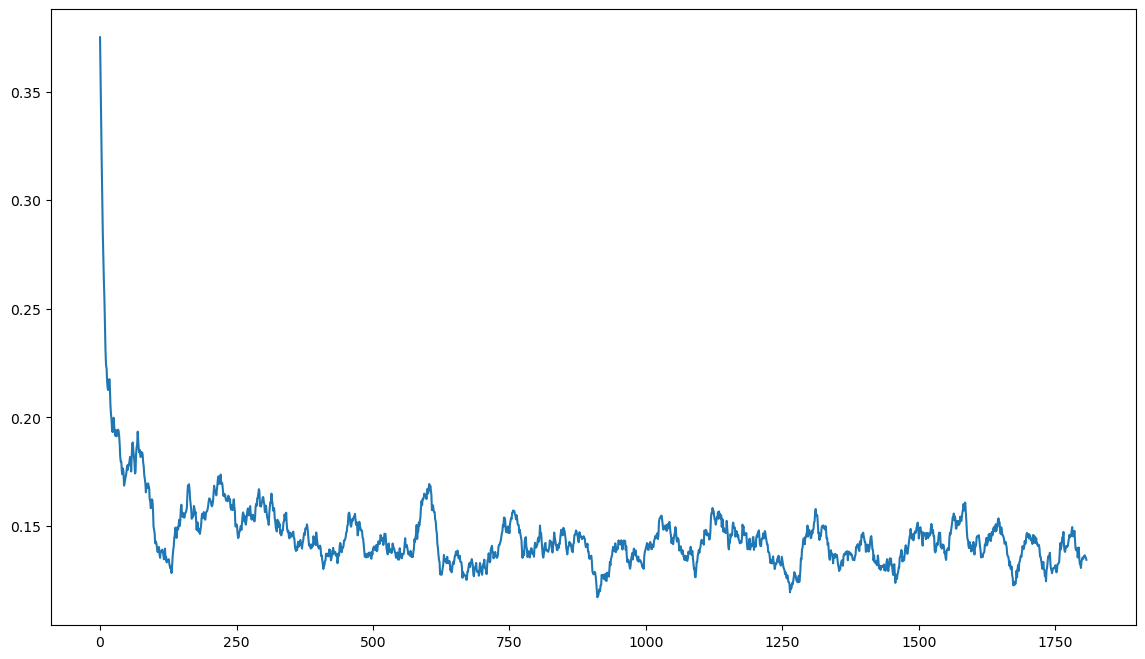

In [81]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [126]:
model.bert_model.save_pretrained(f"cross_ecoder_homer")

In [121]:
def get_answear(
    tokenizer, finetuned_ce, base_bert, query, context, corpus,
    size_patch=150, qty_rand_choose=4, max_out_context=200
):

    # Создаем словарь для хранения оценок и ответов
    dic_answear = {"score": [], "answer": []}

    # Объединяем запрос и контекст памяти
    context_memory = query + "[SEP]" + context

    # Ограничиваем количество случайно выбираемых ответов
    if len(corpus) < qty_rand_choose * max_out_context:
        qty_rand_choose = int(len(corpus))

    # Поскольку база большая, проводим несколько выборов случайных ответов
    for i in range(qty_rand_choose):
        rand_patch_corpus = list(np.random.choice(corpus, size_patch))

        # Токенизируем запросы и случайно выбранные ответы
        queries = [context_memory] * len(rand_patch_corpus)
        tokenized_texts = tokenizer(
            queries, rand_patch_corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
        ).to(DEVICE)

        # Оцениваем модель Finetuned CrossEncoder
        with torch.no_grad():
            ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
            ce_scores = torch.sigmoid(ce_scores)  # Применяем сигмоиду при необходимости

        # Обрабатываем оценки для модели Finetuned
        scores = ce_scores.cpu().numpy()
        scores_ix = np.argsort(scores)[::-1][0]
        dic_answear["score"].append(scores[scores_ix])
        dic_answear["answer"].append(rand_patch_corpus[scores_ix])

    # Находим наилучший ответ и его оценку
    best_answer_index = np.argsort(dic_answear["score"])[::-1][0]
    best_answer = dic_answear["answer"][best_answer_index]

    # Обновляем контекст памяти
    conext_memory = best_answer + "[SEP]" + context_memory
    return best_answer, conext_memory[:max_out_context]

In [124]:
question = "Homer, How are you?"  #
print(f"Реплика: {question}")

Реплика: Homer, How are you?


In [125]:
best_answer = get_answear(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_answers)

print(f"{best_answer}") 

Yeah, I guess your old man is smarter than you thought. Look at 'em standing out there. No place to go. Heh, heh. Poor guys. Hey, what if we let 'em stay here for just a few days?
